# Makemore part 2 (MLP) by paper

In [1042]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(2147483647)

#### Create Dataset

In [1043]:
names = pd.read_csv("../names.txt",names = ["label"])
words = names.label

In [1044]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

In [1045]:
all_stoi = {}
all_itos ={}

all = set("".join(words+"."))
for index,(chr) in enumerate(sorted(all)):
    all_stoi[chr] = index

for index,(chr) in enumerate(sorted(all)):
    all_itos[index] = chr

# all_stoi

In [1046]:
x= []
y = []
blocks = 3

for word in names.label:
    wx = [("."* (blocks - i)) + word  for i in range(blocks)]
    wy = [y.append(all_stoi[i]) for i in (word+".")]
                       
    for ch1,ch2,ch3 in zip(*wx[:len(wx)]):
        x.append((all_stoi[ch1],all_stoi[ch2],all_stoi[ch3]))



x = torch.tensor(x)
y = torch.tensor(y)

train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.2,shuffle=True,stratify = y,random_state=42)
val_x,test_x,val_y,test_y = train_test_split(val_x,val_y,test_size=0.1,stratify = val_y, random_state=42)

train_x,val_x,train_y,val_y = train_x.to(device),val_x.to(device),train_y.to(device),val_y.to(device)
val_x,test_x,val_y,test_y = val_x.to(device),test_x.to(device),val_y.to(device),test_y.to(device)

print(f"train_x: {train_x.shape} train_y: {train_y.shape}")
print(f"val_x: {val_x.shape} val_y: {val_y.shape}")
print(f"test_x: {test_x.shape} test_y: {test_y.shape}")

train_x: torch.Size([182516, 3]) train_y: torch.Size([182516])
val_x: torch.Size([41067, 3]) val_y: torch.Size([41067])
test_x: torch.Size([4563, 3]) test_y: torch.Size([4563])


In [1047]:
# print("x.shape: ",x.shape,"x.dtype: ",x.dtype,"y.shape: ",y.shape,"y.dtype: ",y.dtype)

In [1048]:
# c = torch.randn(27,2)

In [1049]:
# emb = c[x]
# emb.shape

In [1050]:
# W = torch.randn(6,100)
# B = torch.randn(100)

In [1051]:
# z = emb.view(-1,6) @ W + B #-1 automatically pytorch find the other dim and put there 32 cause emb.shape => 32,3,2

In [1052]:
# we know the tanh we use on this upper layer directly but for some understanding purposes
# z = torch.tanh(emb.view(-1,6) @ W + B)
# z.shape

In [1053]:
# W2 = torch.randn(100,27)
# B2 = torch.randn(27)

In [1054]:
# logits = z @ W2+B2
# logits.shape

In [1055]:
# same as Cross Entropy works
# logits = z1.exp()
# prob = logits/logits.sum(1,keepdims=True)
# loss = -prob[torch.arange(32),y].log().mean()
# loss
# Output: 17.6186

# prob[0].sum()   # Ans: 1.0  so it is normalized



# loss = F.cross_entropy(logits,y)
# loss
# Output: 17.6186



In [1056]:
# Parameters
c  = torch.nn.Parameter(torch.randn(27, 20, device=device) * 0.1)

W  = torch.nn.Parameter(torch.randn(60, 500, device=device) * 0.01)
B  = torch.nn.Parameter(torch.zeros(500, device=device))

W2 = torch.nn.Parameter(torch.randn(500, 500, device=device) * 0.01)
B2 = torch.nn.Parameter(torch.zeros(500, device=device))

W3 = torch.nn.Parameter(torch.randn(500, 27, device=device) * 0.01)
B3 = torch.nn.Parameter(torch.zeros(27, device=device))

# Put everything on device
parameters = [c, W, B, W2, B2, W3, B3]


# Optimizer + Scheduler
optimizer = torch.optim.Adam(parameters, lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50000)

# Tracking
lri = []
lossi = []
stepi = []


lr         loss       batch       
0.1 =>     2.8          64
0.01 =>    2.7          64



In [1057]:
for i in range(50000):
    mini_batchx = torch.randint(0,train_x.shape[0],(512,), device = device) # mini batches make execution faster and boost the forward, backward pass
    # Forward pass
    emb = c[train_x[mini_batchx]] # [32, 3, 2]
    z = torch.tanh(emb.view(-1,60) @ W + B) # [32, 300]
    z1 = torch.tanh(z @ W2 + B2) # [300, 300]
    logits = z1 @ W3+B3 #[300, 27]
    loss = F.cross_entropy(logits,train_y[mini_batchx])
    
    # Backward pass
    # for p in parameter:
    #     p.grad = None
    # loss.backward()
    # for p in parameter:
    #     p.data += -lr*p.grad

    # Track stats
    # lri.append(lr)

    optimizer.zero_grad()  # Reset gradients
    loss.backward()  # Compute gradients
    optimizer.step()
    scheduler.step()


    lossi.append(loss.log10().item())
    stepi.append(i)

print(f"{loss.item()= }")  

loss.item()= 1.9012610912322998


In [1058]:
# testing on Full dataset 
emb = c[val_x] # [32, 3, 2]
z = torch.tanh(emb.view(-1,60) @ W + B) # [32, 300]
z1 = torch.tanh(z @ W2 + B2) # [300, 300]
logits = z1 @ W3+B3 #[300, 27]logits = z @ W2+B2 #[32, 27]
loss = F.cross_entropy(logits,val_y)
loss



tensor(2.0682, device='mps:0', grad_fn=<NllLossBackward0>)

In [1059]:
# testing on Full dataset 
emb = c[train_x] # [32, 3, 2]
z = torch.tanh(emb.view(-1,60) @ W + B) # [32, 300]
z1 = torch.tanh(z @ W2 + B2) # [300, 300]
logits = z1 @ W3+B3 #[32, 27]
loss = F.cross_entropy(logits,train_y)
loss

tensor(1.9380, device='mps:0', grad_fn=<NllLossBackward0>)

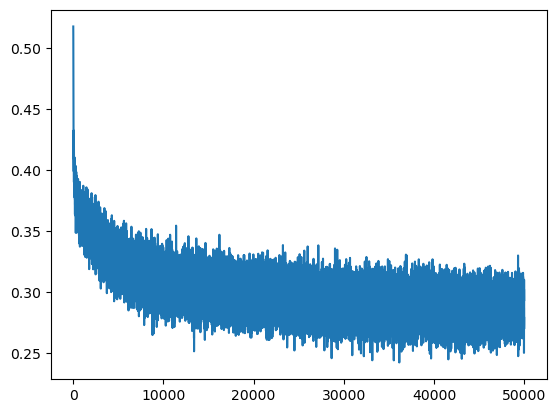

In [1060]:
# plot the data
plt.plot(stepi,lossi)
plt.show()

In [1061]:
# so now you can see here the both loss are nearest and it means the model is underfitting not in overfitting now so we need more additional neurons
# we are make an update on 100 neurons to 300 neurons 


TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

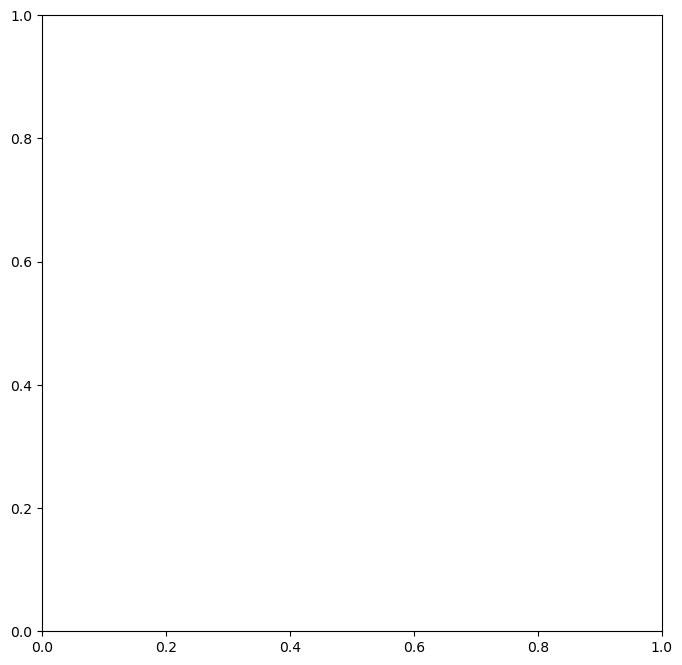

In [ ]:
# plt.figure(figsize = (8,8))
# plt.scatter(c[:,0].data,c[:,1].data,s =200)
# for i in range(c.shape[0]):
#     plt.text(c[i,0].item(), c[i,1].item(), all_itos[i], ha="center", va="center", color='white')
# plt.grid("minor")

In [1065]:
for _ in range(10):
    mini_batchx = torch.randint(0,train_x.shape[0],(32,)) # mini batches make execution faster and boost the forward, backward pass

    out=[]
    context = [0] * blocks
    while True:
        emb = c[torch.tensor([context])] # [32, 3, 2]
        z = torch.tanh(emb.view(1,-1) @ W + B) # [32, 300]
        z1 = torch.tanh(z @ W2 + B2) # [300, 300]
        logits = z1 @ W3+B3 #[32, 27]
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).squeeze(1)
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(all_itos[i.item()] for i in out))



brooks.
dauna.
aleena.
nae.
cyla.
zidia.
love.
charunnah.
samirabella.
mala.
